# Model Evaluation

This notebook is for running and documenting experiments

## latentFairClassifier Evaluation

A classifier based on the model described in the paper 
*Group Fairness by Probabilistic Modeling with Latent Fair Decisions* has been 
successfully implemented and trained on the adult dataset. It is time to 
evaluate the model in terms of fairness as well as traditional metrics.

### Import

In [1]:
import pandas as pd
import sys
import os
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import NaiveBayes
sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from forseti.datproc import translate_categorical, extract_sensitive
from forseti.fairness import parity_score, fairness_report, sns_auc_score
from forseti.bayesnet import latentLabelClassifier
from forseti.datasets import datasetgen_numerical

### Adult Dataset

In [2]:
tmp = pd.read_csv('data/adult.csv')
data, codes = translate_categorical(tmp.copy(deep=True))
sensitive_attributes = ['race', 'gender']

test = data[30000:]

sensitive, features = extract_sensitive(test, sensitive_attributes) 
y = features['income']
X = features.drop('income', axis=1)

y_pred_fair = pd.read_csv('results/y_pred_label_fair.csv', index_col=0)
y_pred_income = pd.read_csv('results/y_pred_label_income.csv', index_col=0)
y_pred_probability = pd.read_csv('results/y_pred.csv', index_col=0)
y_pred_label_NB_sens = pd.read_csv('results/y_pred_label_naive_bayes_sensitive.csv', index_col=0)
y_pred_label_NB_sens.index = y.index
y_pred_label_NB = pd.read_csv('results/y_pred_label_naive_bayes.csv', index_col=0)
y_pred_label_NB.index = y.index
y_pred_prob_NB_sens = pd.read_csv('results/y_pred_probability_naive_bayes_sensitive.csv', index_col=0)
y_pred_prob_NB_sens.index = y.index
y_pred_prob_NB = pd.read_csv('results/y_pred_probability_naive_bayes.csv', index_col=0)
y_pred_prob_NB.index = y.index

### Score metric for demographic parity

Demographic parity is defined as

$$
P(\hat{Y} | S = 0) = P(\hat{Y} | S = 1)
$$

Where $\hat{Y}$ is the predictor and $S$ is the sensitive attribute.

This can be generalised to a multiclass case with $K$ classes.

$$
P(\hat{Y} | S_i) = P(\hat{Y} | S_j) \qquad i, j \in \{0, \dots, K-1\}
$$

We want to condense this to a single metric between $0$ and $1$. I.e, when we 
have likelihood for the different classes of a sensitive attribute in a list of 
probabilities $L$ like so

$$
L =\{ P(\hat{Y} | S=0), \dots, P(\hat{Y} | S=K-1) \}
$$

We would want a score of 1 if that list has probabilities like

$$
L_0 = \{ 0.333, 0.333, 0.333\}
$$

and a score of 0 for

$$
L_1 = \{ 1, 0\}
$$

and for that, we have worked out the following function $f$

$$
    f = 1 - 2\sigma(L)
$$

where $\sigma$ is for standard deviation. The example of which is shown below.

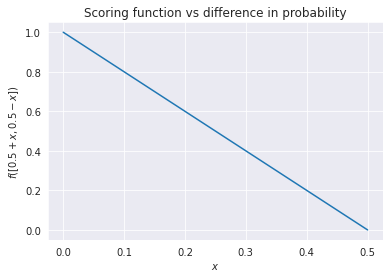

In [3]:
x = np.linspace(0, 0.5, 100)
scores = []

for prob in x:
    scorelist = [0.5 + prob, 0.5 - prob]
    scores.append(parity_score(scorelist))

plt.plot(x, scores);
plt.title('Scoring function vs difference in probability');
plt.xlabel('$x$');
plt.ylabel('$f([0.5+x, 0.5-x])$');
plt.savefig('figures/Parity_metric.png', dpi=200, bbox_inches='tight')
plt.show()

In [4]:
fairnessDF = pd.DataFrame()
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_fair, sensitive, 'FairBN'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_income, sensitive, 'LabelBN'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_label_NB_sens, sensitive, 'NBSens'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_label_NB, sensitive, 'NB'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y, sensitive, 'Dataset'), ignore_index=True);
fairnessDF.round(2)

,Accuracy,Balanced Accuracy,F1 Score,Specificity,Parity Score race,Parity Score gender,Intersectional Parity Score,Model
0,0.82000,0.76000,0.63000,0.89000,0.88000,0.94000,0.87000,FairBN
1,0.83000,0.72000,0.59000,0.94000,0.85000,0.75000,0.78000,LabelBN
2,0.81000,0.79000,0.66000,0.82000,0.77000,0.61000,0.68000,NBSens
3,0.81000,0.80000,0.67000,0.83000,0.82000,0.66000,0.71000,NB
4,1.00000,1.00000,1.00000,1.00000,0.85000,0.80000,0.81000,Dataset


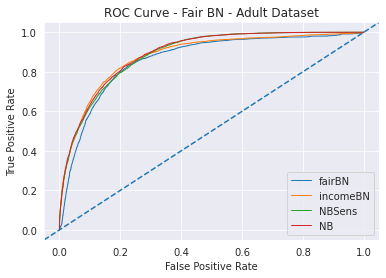

In [5]:
fpr_fair, tpr_fair, threshold = roc_curve(y,  y_pred_probability['fair_0'])
fpr_income, tpr_income, _ = roc_curve(y,  y_pred_probability['income_1'])
fpr_NBsens, tpr_NBsens, _ = roc_curve(y,  y_pred_prob_NB_sens['income_1'])
fpr_NB, tpr_NB, _ = roc_curve(y,  y_pred_prob_NB['income_1'])

#create ROC curve
plt.plot(fpr_fair, tpr_fair, label='fairBN', linewidth=1)
plt.plot(fpr_income, tpr_income, label='incomeBN', linewidth=1)
plt.plot(fpr_NBsens, tpr_NBsens, label='NBSens', linewidth=1)
plt.plot(fpr_NB, tpr_NB, label='NB', linewidth=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axline((1, 1), slope=1, ls="--")
plt.legend()
plt.title('ROC Curve - Fair BN - Adult Dataset')
plt.savefig('figures/adult_fairbn_roc.png', dpi=200, bbox_inches='tight')
plt.show()

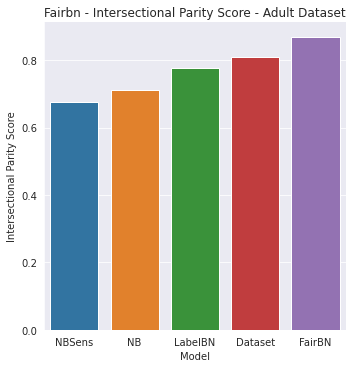

In [6]:
sns.catplot(
    x='Model',
    y='Intersectional Parity Score',
    data=fairnessDF,
    kind='bar',
    order=fairnessDF.sort_values('Intersectional Parity Score').Model
).set(title='Fairbn - Intersectional Parity Score - Adult Dataset')
plt.savefig('figures/adult_fairbn_parity.png', dpi=200, bbox_inches='tight')

### AUC Score Label

In [7]:
roc_auc_score(y, y_pred_probability['fair_0'])

0.8614517131386523

### AUC Score Sensitive

In [8]:
sns_auc_score(sensitive['gender'], y_pred_probability['fair_0'])

0.5696768686163788

### Compas Dataset

In [9]:
scores = pd.read_csv('data/compas-two-yrs-recidivism.csv')
features = [
    'sex',
    'age',
    'race',
    'priors_count',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'c_charge_degree',
    'two_year_recid'
]


tmp = scores[features]
tmp['two_year_recid'] = tmp['two_year_recid'].astype('category')

data, codes = translate_categorical(tmp.copy(deep=True))
sensitive_attributes = ['sex', 'race']

test = data[6000:].reset_index(drop=True)
sensitive, features = extract_sensitive(test, sensitive_attributes) 

y = features['two_year_recid']
X = features.drop('two_year_recid', axis=1)

y_compas_pred = pd.read_csv('results/pred_compas.csv', index_col=0)
y_compas_pred_probability = pd.read_csv('results/pred_compas_probability.csv', index_col=0)
y_compas_pred_NB_sensitive = pd.read_csv('results/pred_compas_NB_sensitive.csv', index_col=0)
y_compas_pred_probability_NB_sensitive = pd.read_csv('results/pred_compas_probability_NB_sensitive.csv', index_col=0)
y_compas_pred_NB = pd.read_csv('results/pred_compas_NB.csv', index_col=0)
y_compas_pred_probability_NB = pd.read_csv('results/pred_compas_probability_NB.csv', index_col=0)

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [10]:
fairnessDF = pd.DataFrame()

fairnessDF = fairnessDF.append(fairness_report(y, y_compas_pred['fair'], sensitive, 'FairBN'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_compas_pred['two_year_recid'], sensitive, 'LabelBN'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_compas_pred_NB_sensitive['two_year_recid'], sensitive, 'NBSens'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_compas_pred_NB['two_year_recid'], sensitive, 'NB'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y, sensitive, 'Dataset'), ignore_index=True);
fairnessDF.round(2)

,Accuracy,Balanced Accuracy,F1 Score,Specificity,Parity Score sex,Parity Score race,Intersectional Parity Score,Model
0,0.60000,0.56000,0.28000,0.96000,0.94000,0.90000,0.91000,FairBN
1,0.60000,0.57000,0.28000,0.96000,0.95000,0.66000,0.45000,LabelBN
2,0.64000,0.62000,0.52000,0.81000,0.70000,0.56000,0.38000,NBSens
3,0.64000,0.64000,0.61000,0.64000,0.91000,0.54000,0.49000,NB
4,1.00000,1.00000,1.00000,1.00000,0.94000,0.54000,0.50000,Dataset


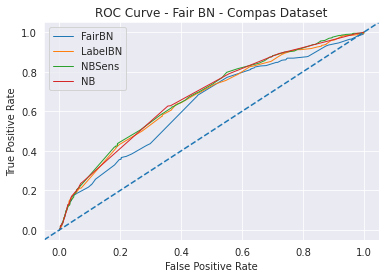

In [11]:
fpr_fair, tpr_fair, threshold = roc_curve(y,  y_compas_pred_probability['fair_1'])
fpr_income, tpr_income, _ = roc_curve(y,  y_compas_pred_probability['two_year_recid_1'])
fpr_nbsens, tpr_nbsens, _ = roc_curve(y,  y_compas_pred_probability_NB_sensitive['two_year_recid_1'])
fpr_nb, tpr_nb, _ = roc_curve(y,  y_compas_pred_probability_NB['two_year_recid_1'])

#create ROC curve
plt.close()
plt.plot(fpr_fair, tpr_fair, label='FairBN', linewidth=1)
plt.plot(fpr_income, tpr_income, label='LabelBN', linewidth=1)
plt.plot(fpr_nbsens, tpr_nbsens, label='NBSens', linewidth=1)
plt.plot(fpr_nb, tpr_nb, label='NB', linewidth=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axline((1, 1), slope=1, ls="--")
plt.legend()
plt.title('ROC Curve - Fair BN - Compas Dataset')
plt.savefig('figures/compas_fairbn_roc.png', dpi=200, bbox_inches='tight')
plt.show()

### AUC score label

In [12]:
roc_auc_score(y, y_compas_pred_probability['fair_1'])

0.6343219956879238

### AUC Score Sensitive

In [13]:
sns_auc_score(sensitive['sex'], y_compas_pred_probability['fair_0'])

0.5623917773399745

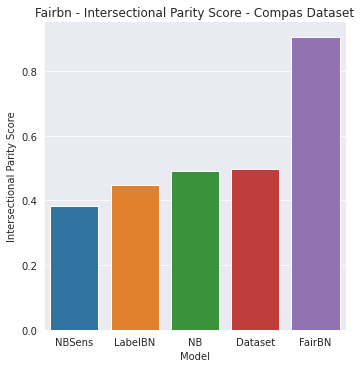

In [14]:
sns.catplot(
    x='Model',
    y='Intersectional Parity Score',
    data=fairnessDF,
    kind='bar',
    order=fairnessDF.sort_values('Intersectional Parity Score').Model
).set(title='Fairbn - Intersectional Parity Score - Compas Dataset')
plt.savefig('figures/compas_fairbn_parity.png', dpi=200, bbox_inches='tight')

# Fair Tree Algorithm

## Adult Dataset

In [15]:
tmp = pd.read_csv('data/adult.csv')
data, codes = translate_categorical(tmp.copy(deep=True))
sensitive_attributes = ['race', 'gender']

test = data[30000:]

sensitive, features = extract_sensitive(test, sensitive_attributes) 
y = features['income']
X = features.drop('income', axis=1)

pred_adult_FRFC03 = pd.read_csv('results/pred_adult_FRFC_0.3.csv', index_col=0)
pred_adult_FRFC05 = pd.read_csv('results/pred_adult_FRFC_0.5.csv', index_col=0)
pred_adult_FRFC07 = pd.read_csv('results/pred_adult_FRFC_0.7.csv', index_col=0)
pred_adult_prob_FRFC03 = pd.read_csv('results/pred_adult_prob_FRFC_0.3.csv', index_col=0)
pred_adult_prob_FRFC05 = pd.read_csv('results/pred_adult_prob_FRFC_0.5.csv', index_col=0)
pred_adult_prob_FRFC07 = pd.read_csv('results/pred_adult_prob_FRFC_0.7.csv', index_col=0)

### Fairness Report

In [16]:
fairnessDF = pd.DataFrame()
fairnessDF = fairnessDF.append(fairness_report(y, pred_adult_FRFC03, sensitive, 'FRFC03'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, pred_adult_FRFC05, sensitive, 'FRFC05'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, pred_adult_FRFC07, sensitive, 'FRFC07'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y, sensitive, 'Dataset'), ignore_index=True);
fairnessDF.round(2)

,Accuracy,Balanced Accuracy,F1 Score,Specificity,Parity Score race,Parity Score gender,Intersectional Parity Score,Model
0,0.54000,0.65000,0.47000,0.44000,0.88000,0.79000,0.78000,FRFC03
1,0.66000,0.75000,0.57000,0.58000,0.86000,0.67000,0.71000,FRFC05
2,0.42000,0.61000,0.45000,0.24000,0.88000,0.80000,0.77000,FRFC07
3,1.00000,1.00000,1.00000,1.00000,0.85000,0.80000,0.81000,Dataset


### ROC Curve

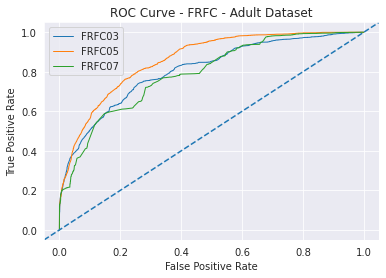

In [17]:
fpr_fair, tpr_fair, threshold = roc_curve(y,  pred_adult_prob_FRFC03)
fpr_income, tpr_income, _ = roc_curve(y,  pred_adult_prob_FRFC05)
fpr_NBsens, tpr_NBsens, _ = roc_curve(y,  pred_adult_prob_FRFC07)

#create ROC curve
plt.plot(fpr_fair, tpr_fair, label='FRFC03', linewidth=1)
plt.plot(fpr_income, tpr_income, label='FRFC05', linewidth=1)
plt.plot(fpr_NBsens, tpr_NBsens, label='FRFC07', linewidth=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axline((1, 1), slope=1, ls="--")
plt.legend()
plt.title('ROC Curve - FRFC - Adult Dataset')
plt.savefig('figures/adult_frfc_roc.png', dpi=200, bbox_inches='tight')
plt.show()

### AUC Score Label

In [18]:
roc_auc_score(y, pred_adult_prob_FRFC05)

0.8601396813312248

### AUC Score Sensitive

In [19]:
sns_auc_score(sensitive['gender'], pred_adult_prob_FRFC05)

0.7139815374554921

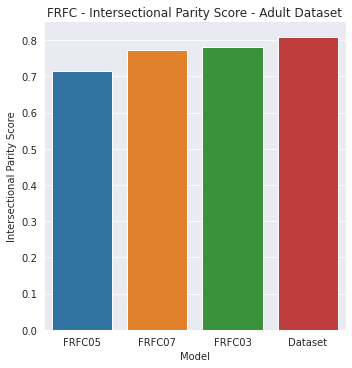

In [20]:
sns.catplot(
    x='Model',
    y='Intersectional Parity Score',
    data=fairnessDF,
    kind='bar',
    order=fairnessDF.sort_values('Intersectional Parity Score').Model
).set(title='FRFC - Intersectional Parity Score - Adult Dataset')
plt.savefig('figures/adult_frfc_parity.png', dpi=200, bbox_inches='tight')

## Compas Dataset

In [21]:
scores = pd.read_csv('data/compas-two-yrs-recidivism.csv')
features = [
    'sex',
    'age',
    'race',
    'priors_count',
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'c_charge_degree',
    'two_year_recid'
]

tmp = scores[features]
tmp['two_year_recid'] = tmp['two_year_recid'].astype('category')

data, codes = translate_categorical(tmp.copy(deep=True))
sensitive_attributes = ['sex', 'race']

test = data[6000:]
sensitive, features = extract_sensitive(test, sensitive_attributes) 

y = features['two_year_recid']
X = features.drop('two_year_recid', axis=1)

pred_compas_FRFC03 = pd.read_csv('results/pred_compas_FRFC_0.3.csv', index_col=0)
pred_compas_FRFC05 = pd.read_csv('results/pred_compas_FRFC_0.5.csv', index_col=0)
pred_compas_FRFC07 = pd.read_csv('results/pred_compas_FRFC_0.7.csv', index_col=0)
pred_compas_prob_FRFC03 = pd.read_csv('results/pred_compas_prob_FRFC_0.3.csv', index_col=0)
pred_compas_prob_FRFC05 = pd.read_csv('results/pred_compas_prob_FRFC_0.5.csv', index_col=0)
pred_compas_prob_FRFC07 = pd.read_csv('results/pred_compas_prob_FRFC_0.7.csv', index_col=0)

/home/bcwein/anaconda3/envs/forseti/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### Fairness Report

In [22]:
fairnessDF = pd.DataFrame()
fairnessDF = fairnessDF.append(fairness_report(y, pred_compas_FRFC03, sensitive, 'FRFC03'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, pred_compas_FRFC05, sensitive, 'FRFC05'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, pred_compas_FRFC07, sensitive, 'FRFC07'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y, sensitive, 'Dataset'), ignore_index=True);
fairnessDF.round(2)

,Accuracy,Balanced Accuracy,F1 Score,Specificity,Parity Score sex,Parity Score race,Intersectional Parity Score,Model
0,0.53000,0.56000,0.64000,0.20000,0.99000,0.82000,0.82000,FRFC03
1,0.61000,0.59000,0.39000,0.91000,0.90000,0.66000,0.45000,FRFC05
2,0.46000,0.50000,0.63000,0.00000,1.00000,1.00000,1.00000,FRFC07
3,1.00000,1.00000,1.00000,1.00000,0.94000,0.54000,0.50000,Dataset


### ROC Curve

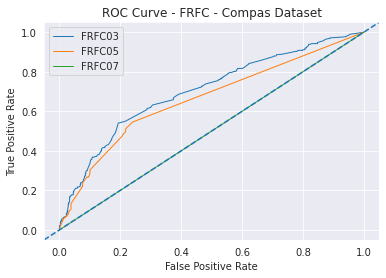

In [23]:
fpr_fair, tpr_fair, threshold = roc_curve(y,  pred_compas_prob_FRFC03)
fpr_income, tpr_income, _ = roc_curve(y,  pred_compas_prob_FRFC05)
fpr_NBsens, tpr_NBsens, _ = roc_curve(y,  pred_compas_prob_FRFC07)

#create ROC curve
plt.plot(fpr_fair, tpr_fair, label='FRFC03', linewidth=1)
plt.plot(fpr_income, tpr_income, label='FRFC05', linewidth=1)
plt.plot(fpr_NBsens, tpr_NBsens, label='FRFC07', linewidth=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axline((1, 1), slope=1, ls="--")
plt.legend()
plt.title('ROC Curve - FRFC - Compas Dataset')
plt.savefig('figures/compas_frfc_roc.png', dpi=200, bbox_inches='tight')
plt.show()

### AUC Score Label

In [24]:
roc_auc_score(y, pred_compas_prob_FRFC03)

0.7021483867970673

## AUC Score Sensitive

In [25]:
sns_auc_score(sensitive['sex'], pred_compas_prob_FRFC05)

0.5761435099307787

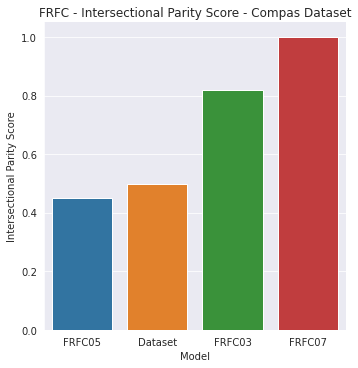

In [26]:
sns.catplot(
    x='Model',
    y='Intersectional Parity Score',
    data=fairnessDF,
    kind='bar', 
    order=fairnessDF.sort_values('Intersectional Parity Score').Model
).set(title='FRFC - Intersectional Parity Score - Compas Dataset')
plt.savefig('figures/compas_frfc_parity.png', dpi=200, bbox_inches='tight')

# Synthetic Datasets

## 1000 Samples, Informative sensitives, numerical

In [27]:
df = datasetgen_numerical(
    n_samples=1000,
    seperability=3,
    informative=True
)

sensitives = ['Gender', 'Race']
label = 'Success'
train = df[:700]
test = df[700:]
sensitive, features = extract_sensitive(test, sensitives) 

clf = latentLabelClassifier(
    train,
    sensitives,
    label,
    atol=0.01
)

clf.fit()

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

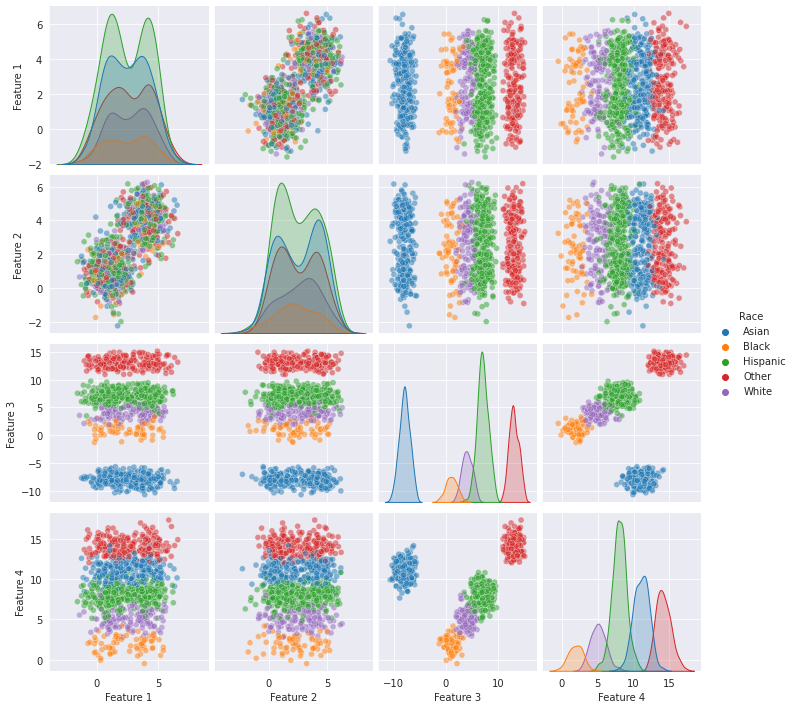

In [28]:
sns.pairplot(
    data=df,
    hue='Race',
    plot_kws={'alpha':0.5}
)

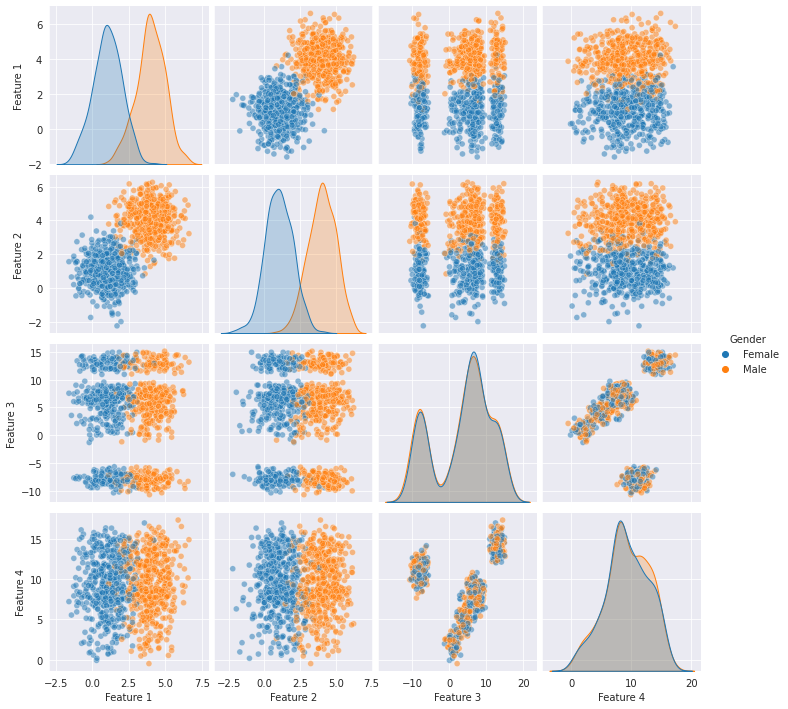

In [29]:
sns.pairplot(
    data=df,
    hue='Gender',
    plot_kws={'alpha':0.5}
)

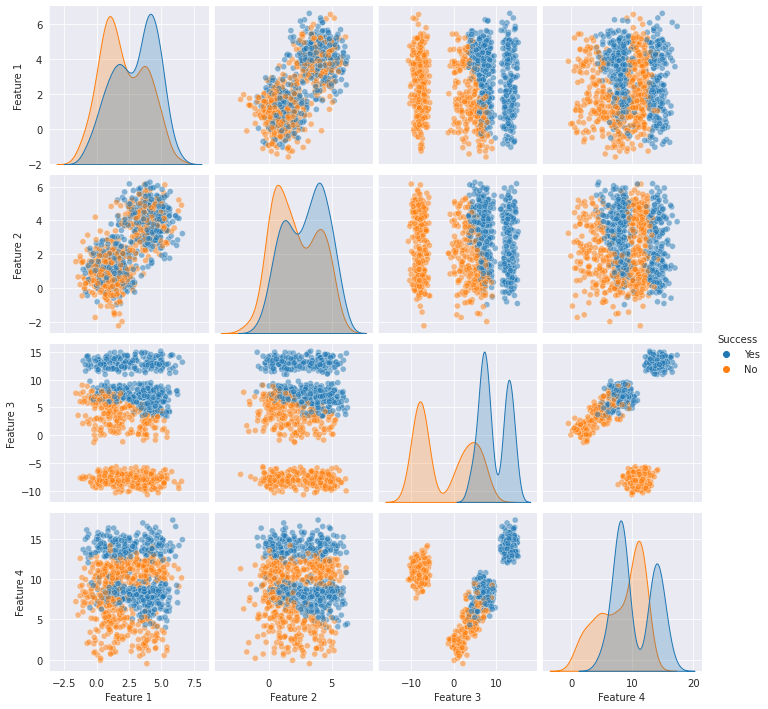

In [30]:
sns.pairplot(
    data=df,
    hue='Success',
    plot_kws={'alpha':0.5}
)

In [31]:
tmp, _ = translate_categorical(test);
y = tmp['Success'];
tmp = tmp.drop('Success', axis=1);

y_pred = clf.predict(tmp)

naindexes = y_pred.isna().any(axis=1)
y_pred[naindexes] = 0
y_pred.index = y.index

/home/bcwein/Code/Forseti/forseti/datproc.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[obj] = dataframe[obj].astype('category')
/home/bcwein/Code/Forseti/forseti/datproc.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[num] = pd.cut(dataframe[num], 5, duplicates='drop')
/home/bcwein/Code/Forseti/forseti/datproc.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

  0%|          | 0/106 [00:00<?, ?it/s]

## Naive Bayes With Sensitive - Predictions

In [32]:
tmp_train, codes_train = translate_categorical(train.copy(deep=True))

model = NaiveBayes();
model.fit(tmp_train, 'Success');
y_pred_naive_sens = model.predict(tmp);
y_pred_prob_naive_sens = model.predict_probability(tmp)
y_pred_naive_sens.index = y.index
y_pred_prob_naive_sens.index = y.index

  0%|          | 0/106 [00:00<?, ?it/s]

## Naive Bayes Without Sensitive - Predictions

In [33]:
tmp_train, codes_train = translate_categorical(train.copy(deep=True))
tmp_train = tmp_train.drop(sensitives, axis=1)

model = NaiveBayes();

tmp = tmp.drop(sensitives, axis=1)
model.fit(tmp_train, 'Success');
y_pred_naive = model.predict(tmp);
y_pred_prob_naive = model.predict_probability(tmp)
y_pred_naive.index = y.index
y_pred_prob_naive.index = y.index

  0%|          | 0/94 [00:00<?, ?it/s]

## Fairness Report

In [34]:
fairnessDF = pd.DataFrame()
fairnessDF = fairnessDF.append(fairness_report(y, y_pred['fair'], sensitive, 'FairBN'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_pred['Success'], sensitive, 'LabelBN'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_naive_sens, sensitive, 'NBSens'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y_pred_naive, sensitive, 'NB'), ignore_index=True);
fairnessDF = fairnessDF.append(fairness_report(y, y, sensitive, 'Dataset'), ignore_index=True);
fairnessDF.round(2)

,Accuracy,Balanced Accuracy,F1 Score,Specificity,Parity Score Gender,Parity Score Race,Intersectional Parity Score,Model
0,0.55000,0.55000,0.42000,0.79000,0.94000,0.94000,0.81000,FairBN
1,0.93000,0.93000,0.93000,0.93000,0.70000,0.21000,0.11000,LabelBN
2,0.90000,0.90000,0.91000,0.84000,0.91000,0.09000,0.08000,NBSens
3,0.90000,0.90000,0.90000,0.84000,0.90000,0.11000,0.10000,NB
4,1.00000,1.00000,1.00000,1.00000,0.75000,0.19000,0.13000,Dataset


## ROC Curve

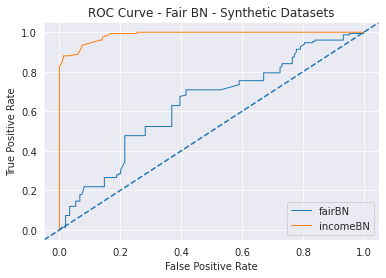

In [35]:
tmp, _ = translate_categorical(test);
y = tmp['Success'];
tmp = tmp.drop('Success', axis=1);

y_pred = clf.predict_probability(tmp)

naindexes = y_pred.isna().any(axis=1)
y_pred[naindexes] = 0
y_pred.index = y.index

fpr_fair, tpr_fair, threshold = roc_curve(y,  y_pred['fair_1'])
fpr_income, tpr_income, _ = roc_curve(y,  y_pred['Success_1'])

#create ROC curve
plt.plot(fpr_fair, tpr_fair, label='fairBN', linewidth=1)
plt.plot(fpr_income, tpr_income, label='incomeBN', linewidth=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axline((1, 1), slope=1, ls="--")
plt.legend()
plt.title('ROC Curve - Fair BN - Synthetic Datasets')
plt.savefig('figures/synthethic_fairbn_roc.png', dpi=200, bbox_inches='tight')
plt.show()

## Experiment 2: Bootstrapping

Now we will train a model and test it on several bootstrapped datasets to get
a sense of the distribution of the fairness metrics.

### Train Models

In [36]:
df = datasetgen_numerical(
    n_samples=1000,
    seperability=3,
    informative=True
)

sensitives = ['Gender', 'Race']
label = 'Success'
train = df[:700]
test = df[700:]
sensitive, features = extract_sensitive(test, sensitives) 

clf = latentLabelClassifier(
    train,
    sensitives,
    label,
    atol=0.01
)

clf.fit()

tmp_train, codes_train = translate_categorical(train.copy(deep=True))
model_sens = NaiveBayes();
model_sens.fit(tmp_train, 'Success');

model = NaiveBayes();
tmp_train = tmp_train.drop(sensitives, axis=1)
model.fit(tmp_train, 'Success');

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
%%capture
import multiprocessing

def sumall(test):
    # Bayesnet Prediction
    tmp_test, _ = translate_categorical(test);
    y = tmp_test['Success'];
    tmp_test = tmp_test.drop('Success', axis=1);

    y_pred = clf.predict(tmp_test)
    naindexes = y_pred.isna().any(axis=1)
    y_pred[naindexes] = 0
    y_pred.index = y.index

    # Naive Bayes Prediction
    y_pred_naive_sens = model_sens.predict(tmp_test);
    y_pred_naive_sens.index = y.index
    
    tmp_test = tmp_test.drop(sensitives, axis=1)
    y_pred_naive = model.predict(tmp_test);
    y_pred_naive.index = y.index

    fairnessDF = pd.DataFrame()
    fairnessDF = fairnessDF.append(fairness_report(y, y_pred['fair'], sensitive, 'FairBN'), ignore_index=True);
    fairnessDF = fairnessDF.append(fairness_report(y, y_pred['Success'], sensitive, 'LabelBN'), ignore_index=True);
    fairnessDF = fairnessDF.append(fairness_report(y, y_pred_naive_sens, sensitive, 'NBSens'), ignore_index=True);
    fairnessDF = fairnessDF.append(fairness_report(y, y_pred_naive, sensitive, 'NB'), ignore_index=True);
    fairnessDF = fairnessDF.append(fairness_report(y, y, sensitive, 'Dataset'), ignore_index=True);
    fairnessDF.round(2)
    return fairnessDF

pool_obj = multiprocessing.Pool();

bootstraps = 100

datasets = test.sample(frac=bootstraps, replace=True);
datasets = np.array_split(datasets, bootstraps);
answer = pool_obj.map(sumall, datasets);
experiment2 = pd.concat(answer, ignore_index=True)
experiment2.to_csv('results/experiment2_parity.csv')

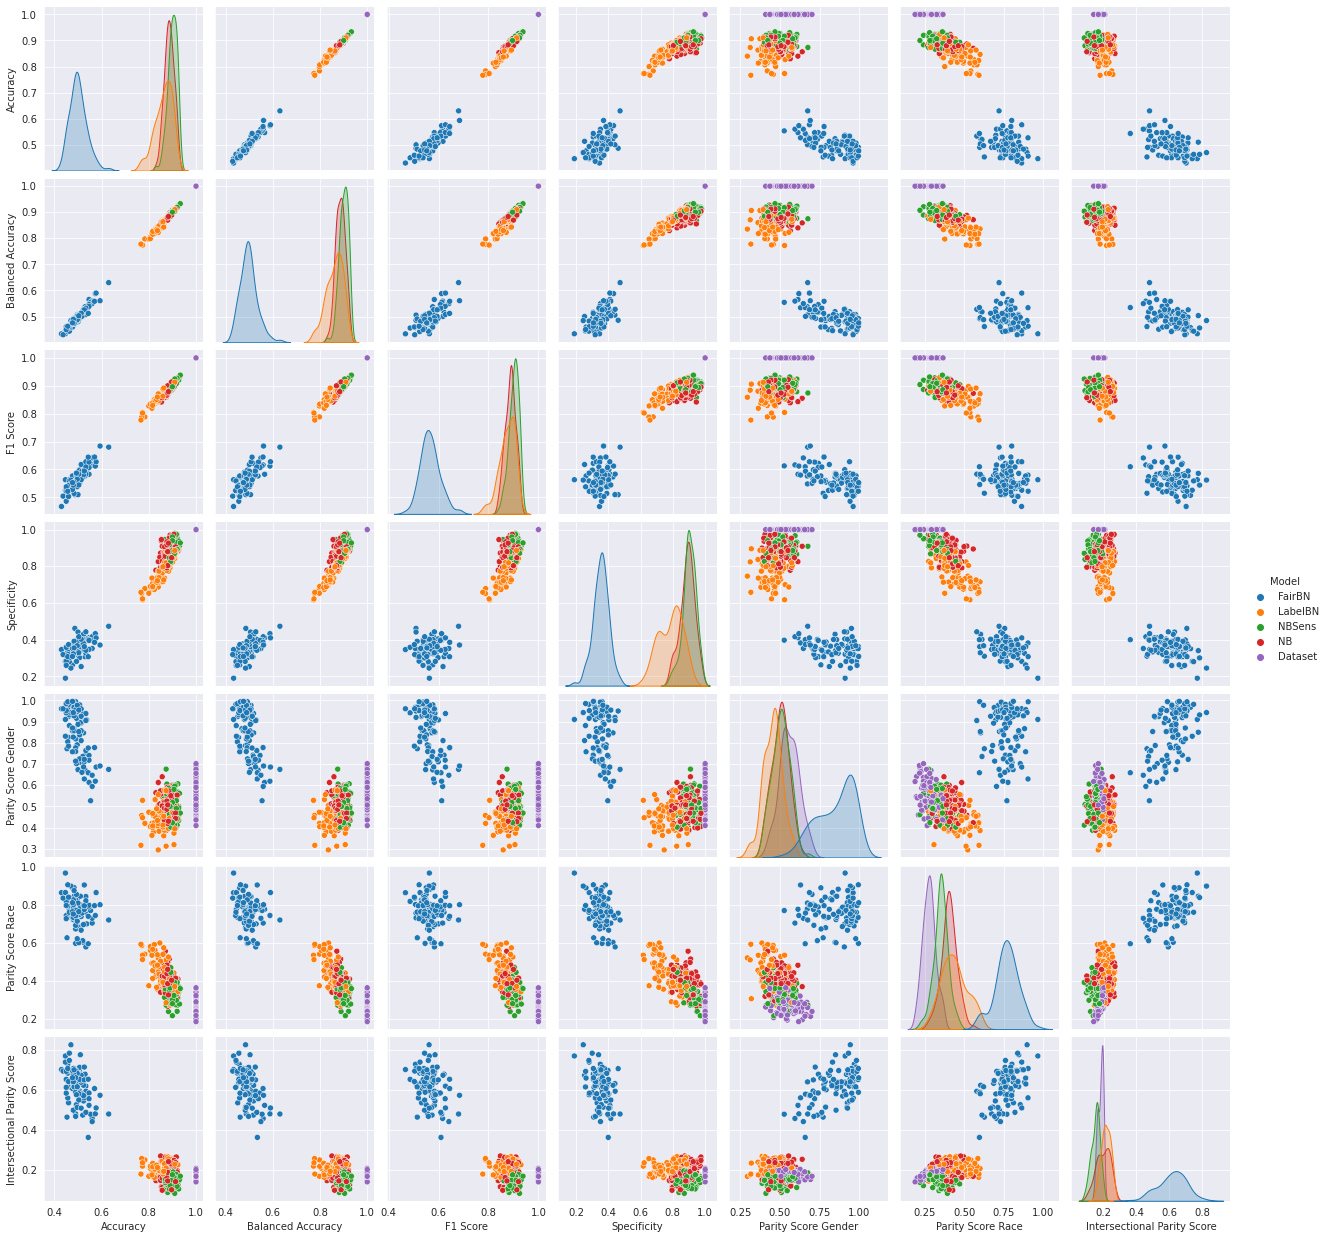

In [38]:
sns.pairplot(
    data=experiment2,
    hue='Model'
)